# Bayesian estimation and regression with pymc3

We can convert frequentist models we have been using before to their Bayesian counterparts. In this lab we will be starting incrementally: replacing the frequentist t-test with Bayesian estimation as well as performing a Bayesian regression with one predictor.

---

### Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### pymc3 is the bayesian modeling package used in this lab

There is also pymc (or pymc2) which has a different syntax. pymc2 is in my opinion harder for beginners to Bayesian statistics to understand; pymc3 bridges the gap better for those who are more familiar with constructing models using frequentist style models/syntax.

In [2]:
import pymc3 as pm

---

### Starcraft dataset

This dataset has records of different player statistics while they are playing Starcraft competitively. There are a variety of columns that are described in detail within the `description.txt` folder contained inside the same folder.

For the examples in this lab, I will be using APM (actions per minute) and Age, but I recommend looking at other variables as well.

In [3]:
star = pd.read_csv('SkillCraft1_Dataset.csv')

In [4]:
star.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


---

## Alternative to t-testing with Bayesian estimation

[This example is adapted from the documentation here.](http://pymc-devs.github.io/pymc3/notebooks/BEST.html) In the example the student-t distribution is used instead of the normal distribution like I use below. This is more appropriate, but more complicated due to the parameterization of the t-distribution. If you're feeling bold try doing this with the t-distribution like in the documentation!

In the following code, I will be using Bayesian posterior estimation to look at the difference in APM between 19 year old players and 26 year old players.

In frequentist statistics, calculating the mean difference between groups is typically done with a t-test. In a t-test we state a null hypothesis (H0) that there is no diffference between groups, then evaluate the probability that we could have gotten this data when the null hypothesis is true.

The de facto standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. This rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

The bayesian approach for evaluating differences between groups is "estimation" rather than "testing". Instead of asking "are the two groups different?", we instead ask "_how_ different are the two groups?" This is the subtle difference in estimation as opposed to testing. We are measuring the extent of the difference between the groups, whether it is zero or any other value.

For a more detailed treatment feel free to read the documentation linked above.

---

### Load 19 year olds and 26 year olds

In [5]:
apm19 = star[star.Age == '19'].APM.values
apm26 = star[star.Age == '26'].APM.values

---

### Set up the bayesian model and priors on means

First we find the mean and standard deviation of APM regardless of age group. We are going to use these values to inform our priors, or current beliefs about APM.

In [6]:
mean_prior_mean = star.APM.mean()
mean_prior_std = star.APM.std()

pymc3 sets up models using the `with ... :` syntax in python.

The first thing we are going to set up is our prior belief about the mean APM for our 19 year olds and 26 year olds. _These are not fixed values,_ but rather normal distributions covering a range of possible values for the mean APM for each group with varying likelihoods.

We are going to set up the normal distributions to both take the overall mean and standard deviation of the actions per minute for all players. In other words, our prior belief for each group's mean APM is the same.

In [7]:
# model specifications in PyMC3 are wrapped in a with-statement
with pm.Model() as model:

    group19_mean = pm.Normal('APM_19yo_mean', mean_prior_mean, sd=mean_prior_std)
    group26_mean = pm.Normal('APM_26yo_mean', mean_prior_mean, sd=mean_prior_std)

---

### Priors on standard deviations

What we set up before are the prior distributions for the _means_ of APM for the two age groups, but we can also set up priors on the standard deviations for APM for each group. In fact, we have to have a prior belief about the distribution of APM for each age group.

Our standard deviation priors will be uniformly distributed from close to 0 up to 100. This is an uninformative prior, saying that we believe all standard deviations in those ranges to be equally likely.

In [8]:
std_prior_lower = 0.01
std_prior_upper = 100.0

with model:
    
    group19_std = pm.Uniform('APM_19yo_std', lower=std_prior_lower, upper=std_prior_upper)
    group26_std = pm.Uniform('APM_26yo_std', lower=std_prior_lower, upper=std_prior_upper)

---

### Set up the APM distributions for groups

Now that we have our prior beliefs about the mean and standard deviation of APM for each age group, we can construct what will be the posterior distributions for the APMs after we have observed the data.

For each group we set up a `pm.Normal` distribution to represent the posterior APM. The mean `mu=` will be our prior belief distribution of the mean for that group. Likewise the `sd=` will be the prior distribution for standard deviation of APM for that group. 

Lastly, we give the posteriors an `observed=` parameter which is the actual APM data. When we "fit" this model using MCMC, the posterior distributions will be updated according to our prior beliefs and our data just like in Bayes formula.

In [9]:
with model:

    group19 = pm.Normal('APM_19yo', mu=group19_mean, sd=group19_std, observed=apm19)
    group26 = pm.Normal('APM_26yo', mu=group26_mean, sd=group26_std, observed=apm26)

---

### Defining additional metrics

The last thing we'll do before fitting the model is defining some distributions that will help us evaluate our question about differences between mean APMs. 

The `pm.Deterministic` distributions are defined from other distributions in the model. For example, below we set up `diff_of_means` to be defined by `group19_mean - group26_mean`, making this a distribution of the differences between means between groups as the posteriors are iteratively fit/estimated.

Effect size is something we have not covered, but it is a normalized measure of the strength of a difference between measures (typically means). We take the difference between means and divide by the pooled standard deviation. Our effect size is guaranteed to lie betweeen -1 and 1, with 0 indicating no difference.

In [10]:
with model:

    diff_of_means = pm.Deterministic('difference of means', group19_mean - group26_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group19_std - group26_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group19_std**2 + group26_std**2) / 2))


---

### Fitting the model with MCMC

When we call `trace = pm.sample(...)` we are starting the process of Markov Chain Monte Carlo (MCMC) estimation of posteriors. The details of thi process we will be covering soon, but essentially it is a sampling algorithm that lets us construct arbitrary posterior distributions given our data and priors.

You'll see "NUTS" being printed out when it is run, along with a progress bar. "NUTS" stands for No U-Turn Sampler and is a state-of-the-art MCMC algorithm.

The "trace" is a collection of all the values on the posterior distribution visited by the MCMC sampling. The values in the trace define the posterior distribution.

In [11]:
with model:
    trace = pm.sample(25000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2,369.7: 100%|██████████| 200000/200000 [00:23<00:00, 8619.68it/s]
Finished [100%]: Average ELBO = -2,369.6
100%|██████████| 25000/25000 [01:42<00:00, 244.58it/s]


---

### Plotting posteriors and result distributions

pymc3 comes with convenient methods for plotting posteriors. Below we plot our posterior means and standard deviations and statistics about the distributions are automatically given to us on the plots.

The HPD is the Highest Posterior Density interval. This gives us a bayesian "credible interval" which is the corollary to the frequentist confidence interval. The 95% HPD says that the 95% highest density points on the distribution fall within that range.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1164906d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1164df710>], dtype=object)

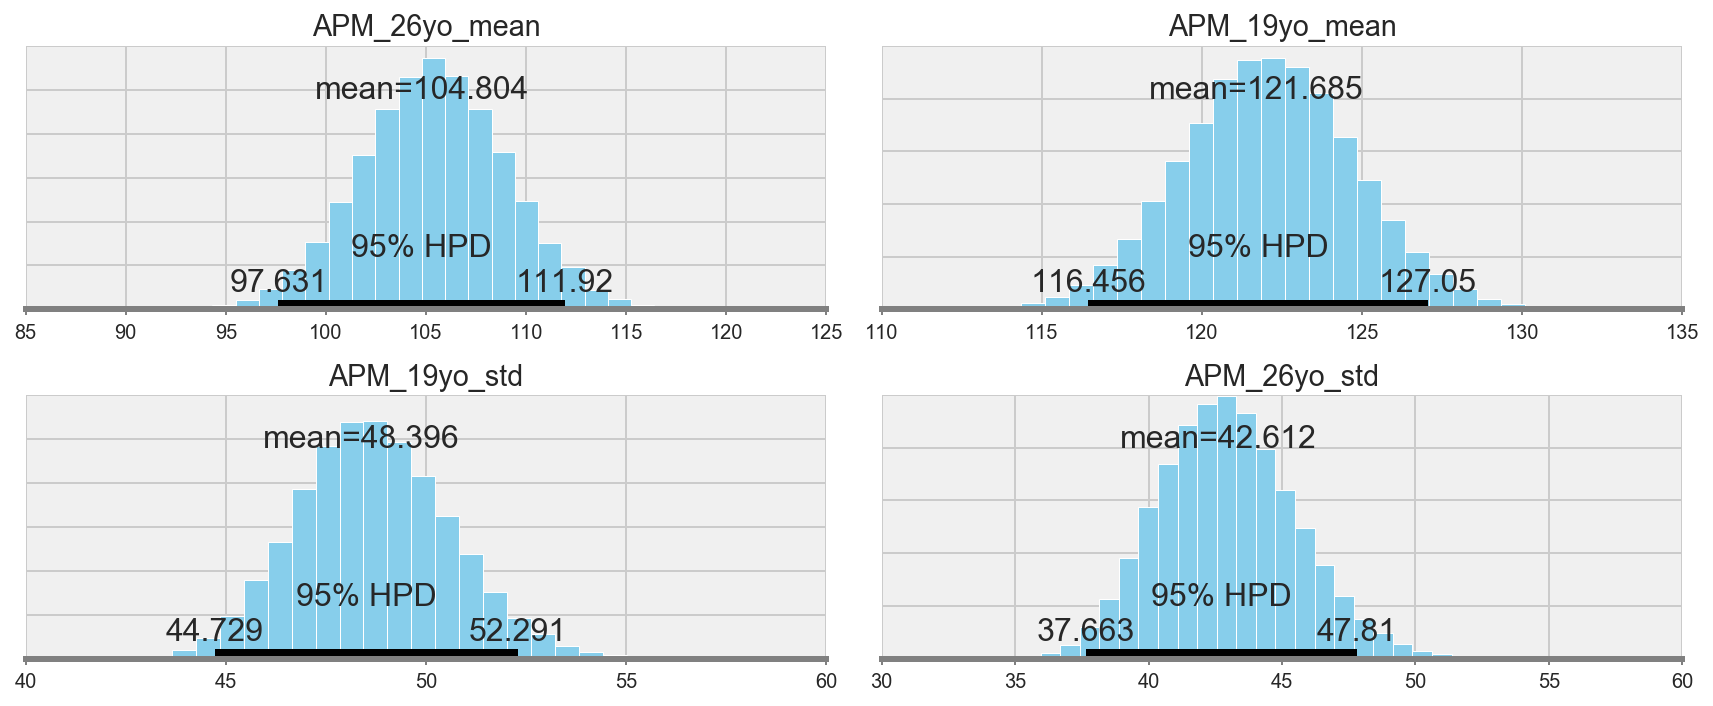

In [12]:
pm.plot_posterior(trace[3000:],
                  varnames=['APM_19yo_mean', 'APM_26yo_mean', 'APM_19yo_std', 'APM_26yo_std'],
                  color='#87ceeb')

We can also plot out our distributions that we defined to explicitly measure the statistics we were interested in, like the difference in mean APM between the groups.

The `ref_val` will plot a vertical bar at any value you like to give you a visual reference. In this case, we will choose 0 since we want to see if a portion of our mean difference ditribution overlaps 0.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1165b87d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11c7be710>], dtype=object)

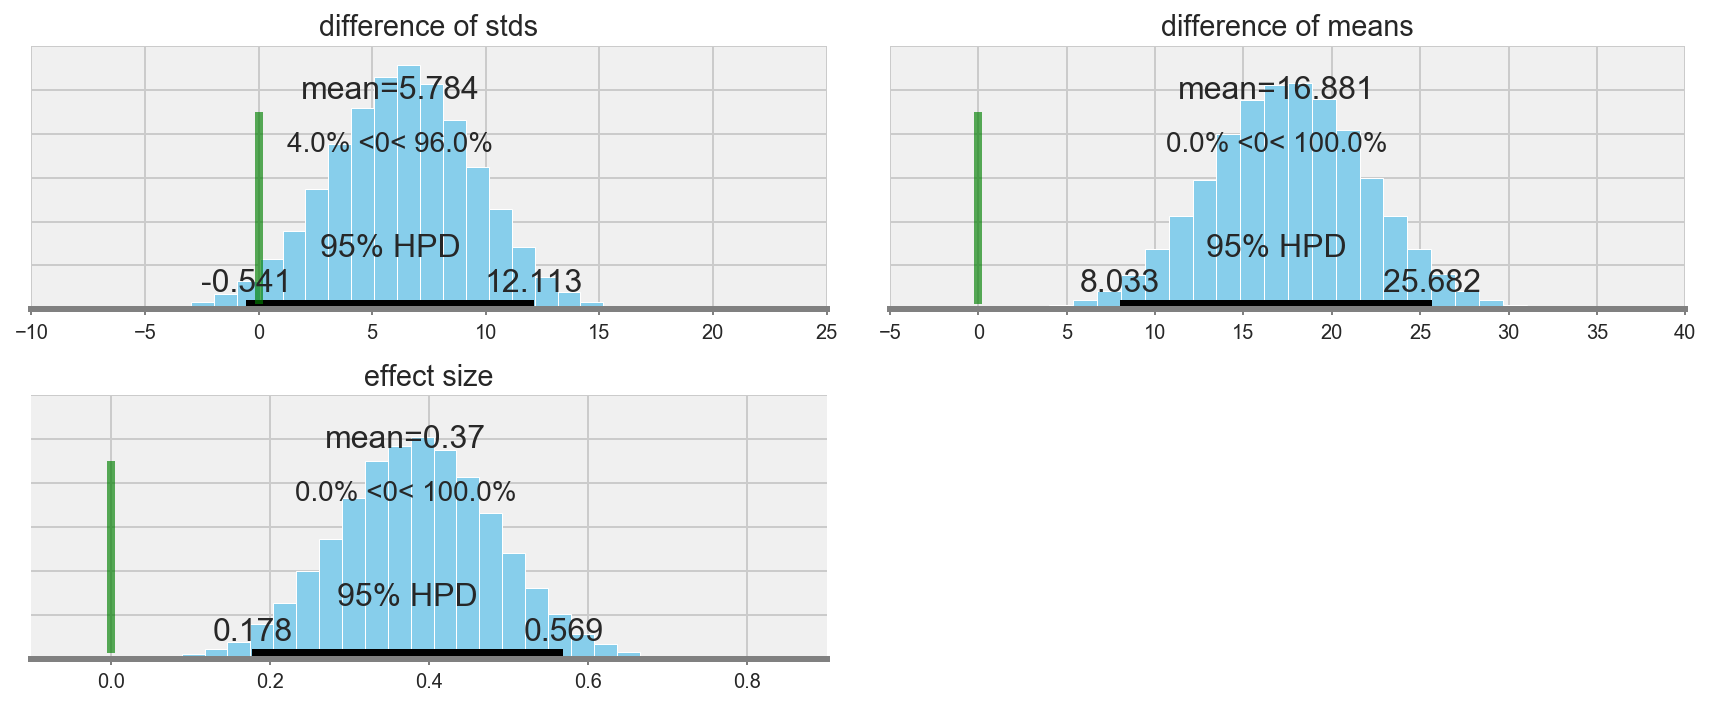

In [13]:
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

Lastly, you can use the `pm.summary` command to print out a text representation of the statistics for the posterior distributions above.

In [14]:
pm.summary(trace[3000:],
           varnames=['difference of means', 'difference of stds', 'effect size'])


difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  16.881           4.519            0.013            [8.033, 25.682]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.065          13.840         16.884         19.917         25.738


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.784            3.237            0.010            [-0.541, 12.113]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.711         3.637          5.838          7.981          11.958


effect size:

  Mean             SD               MC Error         95% HP

---
## [Optional For Independent Time]

## Perform your own comparison with pymc3

Following the code above, choose groups and values to compare by group using the same Bayesian posterior estimation process.

Try playing around with the parameters for the priors. What happens if you make the range of the prior distributions too small?

---

## Bayesian regression using pymc3

We can use the same kind of model setup to perform Bayesian-style regressions as well. [This example is modeled after the generalized linear model (GLM) instructions in the pymc3 documentation.](http://pymc-devs.github.io/pymc3/notebooks/GLM-linear.html)

What are the benefits to taking a Bayesian approach to regression modeling? Just like in our estimation of APM means per group in the above example, when we perform regression with Bayesian statistics we will get out posterior distributions on our intercept and coefficients. This makes it easy to see the entire distribution of possibilities for these coefficients and shows us immediately the degree of uncertainty in our estimate of an effect.

---

### Set up age vs. APM

In [15]:
star.Age.unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [16]:
def num_convert(x):
    try:
        return float(x)
    except:
        return np.nan

star['Age_num'] = star.Age.map(num_convert)

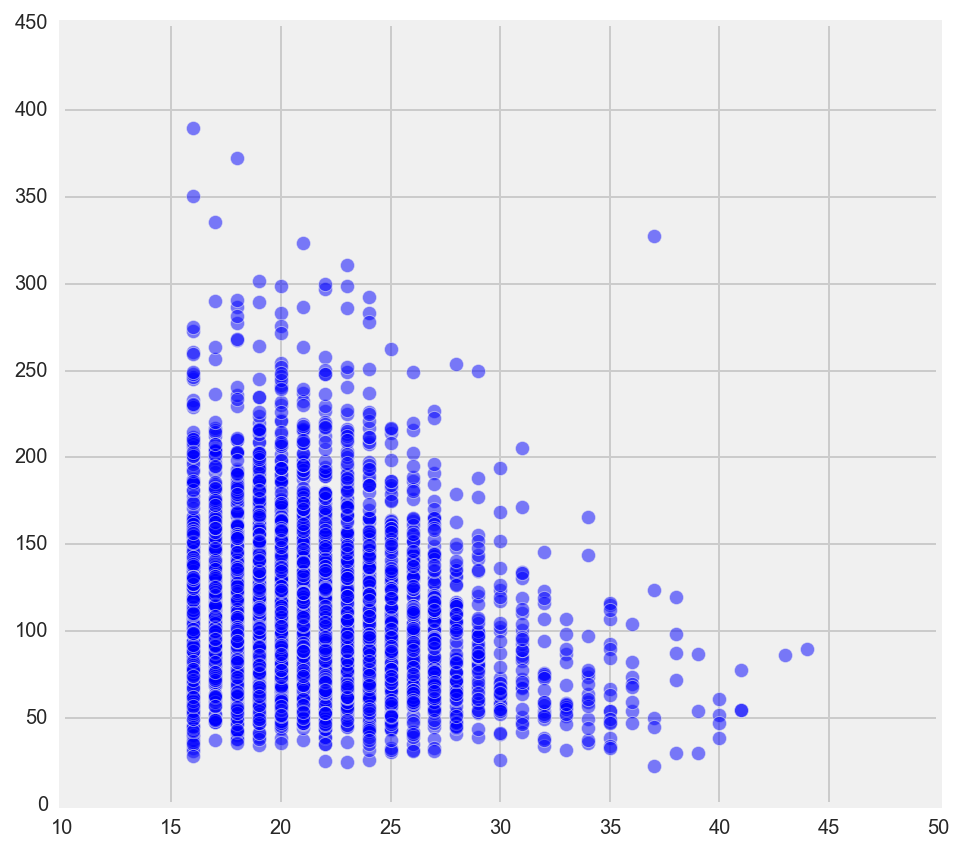

In [17]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(star.Age_num.values, star.APM.values,
           s=50, alpha=0.5)

plt.show()

In [18]:
apm_age = star[['APM','Age_num']].dropna()
apm_age.shape

(3340, 2)

---

### Setting up the Bayesian regression model

Like before, we will construct our model with the `with pm.Model() ...` syntax. 

We have three prior distributions in this case that will be updated to posterior with the data:

1. `apm_std`: which will be our prior belief about the standard deviation of APM values. In this case I am setting it to be uniform (uninformative) between 0.01, and 100..
- `intercept`: a normal distribution for the range of possible values of the intercept.
- `age_beta`: a normal distribution for the range of possible values of the age coefficient.

We set up a `likelihood` distribution that is also normal, representing the distribution of the data (APM) given our predictor. The mean of the likelihood is defined like a regression formula: our intercept distribution plus the age values times our age beta distribution. We give the `apm_std` uniform prior as the standard deviation. Lastly, the observed values, or data, will be the APM values.

What will happen here as MCMC samples is that more likely values (as defined by the mu= regression-style definition) will be "visited" more often. The intercept and age_beta distributions in tandem will have more values visited in places where they result in higher likelihood estimates.

`pm.find_MAP()` tries to find good starting values for our MCMC procedure so that we don't have to run it for as many iterations to get a good posterior representation.

In [19]:

with pm.Model() as regmodel: 
    
    # Define priors:
    apm_std = pm.Uniform('std', lower=0.01, upper=100.)
    
    intercept = pm.Normal('intercept', 0, sd=50.)
    age_beta = pm.Normal('age_beta', 0, sd=50.)

    # Define likelihood:
    likelihood = pm.Normal('apm_hat', mu=intercept + (age_beta * apm_age.Age_num.values),
                           sd=apm_std, observed=apm_age.APM.values)
    
    # Do MCMC to find posteriors:
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(25000, step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 17616.283061
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21


100%|██████████| 25000/25000 [01:07<00:00, 370.03it/s]


`pm.traceplot` can be used to look at the distributions we created in the model across iterations of the MCMC sampling algorithm.

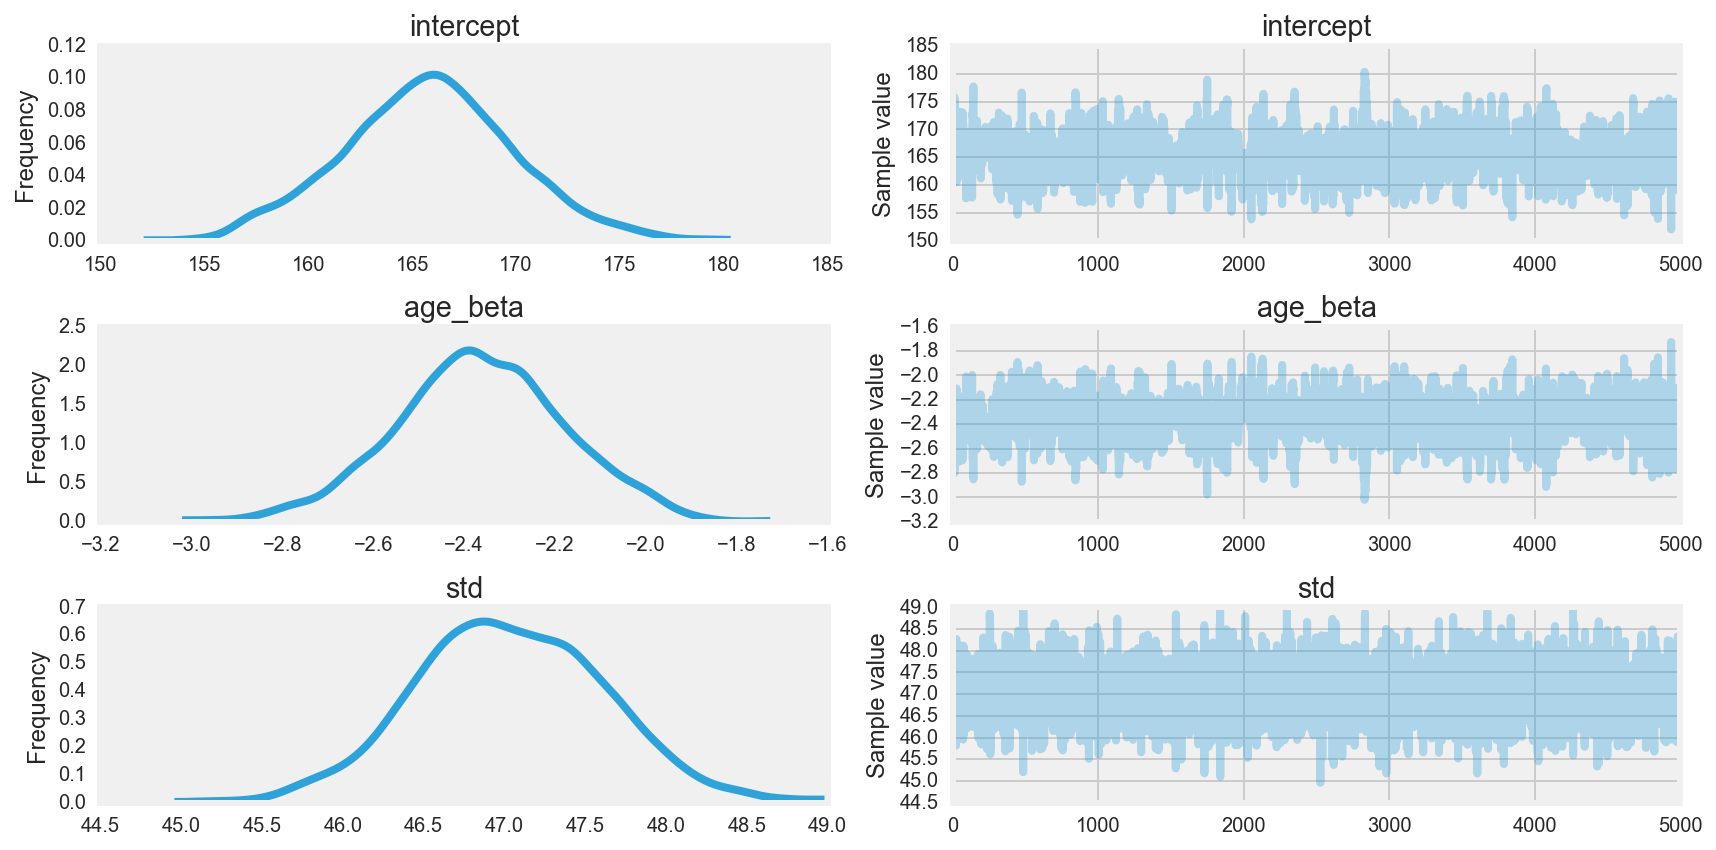

In [20]:
plt.figure(figsize=(7,7))
pm.traceplot(trace[:5000])
plt.tight_layout()

---

### Setting up the model in patsy-style syntax

pymc3 also gives you a convenience function `pm.glm.glm(...` which takes a patsy-style formula definition and the dataframe, and automatically constructs the distributions required to solve the Bayesian regression. Pretty nice.

In [21]:
with pm.Model() as model:
    # With glm, the likelihood and all its parameters are automatically added to our model.
    pm.glm.glm('APM ~ Age_num', apm_age)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(25000, step, progressbar=True) 

         Current function value: 3340593.241514
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5


100%|██████████| 25000/25000 [01:44<00:00, 240.02it/s]


Lastly, you can plot out different possible regression lines with `pm.glm.plot_posterior_predictive`.

This function takes:

- the trace (MCMC samples)
- the number of samples you want to draw out and plot
- an `lm=` argument that will be a function defining how the regression line will be fit using an x value and the sample
- an `eval=` argument that will be the x-values `lm` is evaluated over

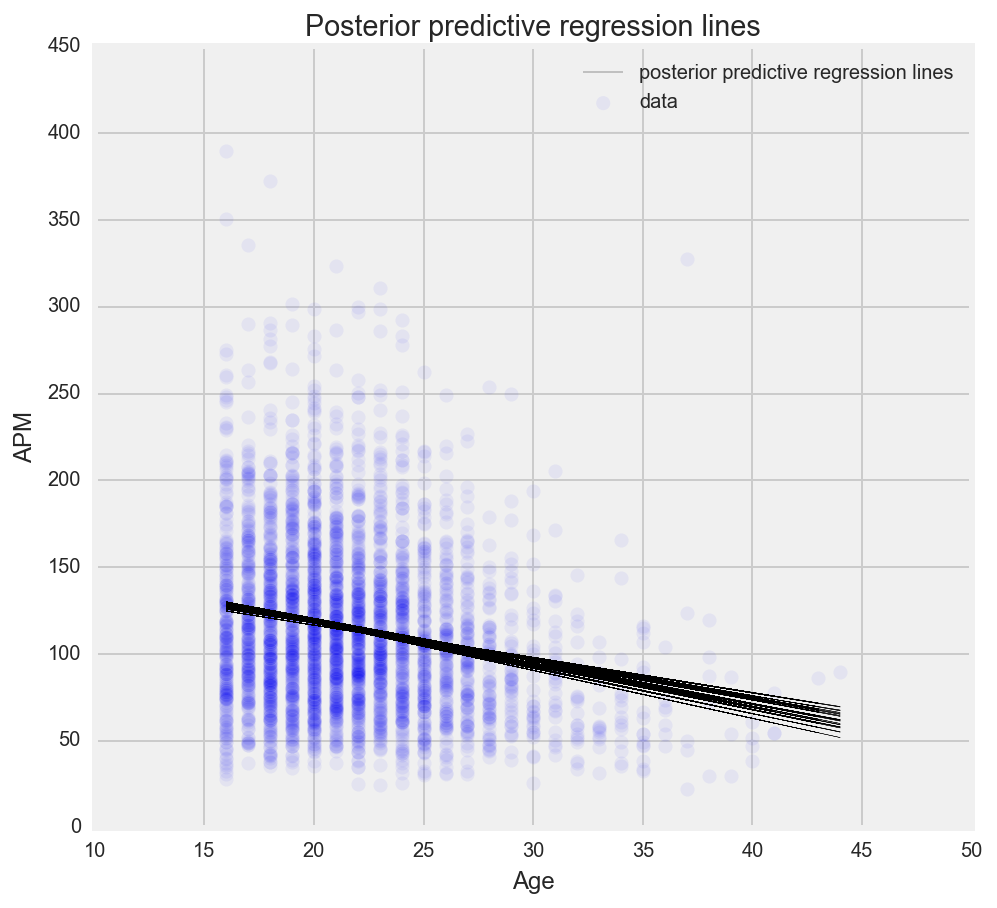

In [22]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(star.Age_num.values, star.APM.values,
           s=50, alpha=0.05, label='data')

pm.glm.plot_posterior_predictive(trace, samples=25, 
                                 lm=lambda x, sample: sample['Intercept'] + sample['Age_num']*x,
                                 eval=star.Age_num.values,
                                 label='posterior predictive regression lines')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('Age')
plt.ylabel('APM')

plt.show()

## Using our model

Now that we have produced Bayesian estimates for our example, we may want to make predictions on out of sample observations. This, implicitly, relies on us doing model validation to assume our model is in the position that we want it to be.

### Posterior prediction checks

Posterior prediction checks are a great way to assess if our model's posterior makes useful predictions against our given dataset. We sample the posterior, and compare those samples against our real data to see how well they performaed. Deeper probabilistic programming will use [root mean squared deviation](https://pymc-devs.github.io/pymc3/notebooks/GLM-hierarchical.html#Posterior-Predictive-Check) to quantify this difference. We will stick to the basics of posterior prediction checks. ([PyMC docs](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Comparison-between-PPC-and-other-model-evaluation-methods.))


A nice summary is as follows:

"Comparing the predictive distribution yrep to the observed data y is generally termed a "posterior predictive check". This type of check includes the uncertainty associated with the estimated parameters of the model, unlike frequentist statistics.

Posterior predictive checks (via the predictive distribution) involve a double-use of the data, which violates the likelihood principle. However, arguments have been made in favor of posterior predictive checks, provided that usage is limited to measures of discrepancy to study model adequacy, not for model comparison and inference (Meng 1994).

Gelman recommends at the most basic level to compare yrep to y, looking for any systematic differences, which could indicate potential failings of the model (Gelman et al. 2004, p. 159). It is often first recommended to compare graphical plots, such as the distribution of y and yrep."

[Source](https://cran.r-project.org/web/packages/LaplacesDemon/vignettes/BayesianInference.pdf)

In [23]:
# sample our model to create posterior prediction checks
ppc = pm.sample_ppc(trace, model=model, samples=100)

100%|██████████| 100/100 [00:01<00:00, 76.93it/s]


In [24]:
# note ppc's charateristics
print(ppc['y'].shape)
print(ppc)

(100, 1, 3340)
{'y': array([[[ 125.50436465,  116.55844498,   55.26029681, ...,  180.73213537,
           29.97387789,  141.96638521]],

       [[ 108.72260628,  190.40073161,  147.42362932, ...,  148.75322273,
          153.66076843,  151.89043659]],

       [[ 119.05456794,   62.28077796,  122.63244964, ...,  132.48530282,
          165.46474639,  166.10558476]],

       ..., 
       [[ 115.43838423,  113.64180907,  174.88678379, ...,   36.39715938,
           48.51063873,   92.9057184 ]],

       [[  81.88752231,  115.91848747,   86.06534782, ...,   92.37398257,
           96.70861992,   71.86036942]],

       [[  41.40813626,   39.09615579,   53.72514971, ...,  134.85572194,
          159.72130169,  150.08680142]]])}


In [25]:
# how many arrays? - the number of samples we ran
print(len(ppc['y']))

100


In [26]:
# grab one array - one sampling of our posterior
print((ppc['y'][0][0]))

[ 125.50436465  116.55844498   55.26029681 ...,  180.73213537   29.97387789
  141.96638521]


In [27]:
# how many values in that one array? - the number of observations in a single sample
len(ppc['y'][0][0])

3340

## Making predictions

Once we're happy with our representation of the data, we can use this representation to make estimates. In fact, that's exactly what we just did previously: we used _many_ estimates to make probabilistic representations of our data.

To condense these many ideas into a closer, single value, we should take the mean of our parameter estimates. The mean of our beta distribution and the mean of our intercept is us making our best guess for what those parameters should be.

(Note that despite converging on a single model, this is still distinct from frequentist MLE [traditional regression techniques]: our estimates for our parameters were derived using MAP, and we're simply averaging those estimates.)

In [28]:
# see our parameters
from pymc3 import summary
summary(trace)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  166.381          5.918            0.229            [157.980, 175.022]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  157.951        163.666        166.541        169.516        175.008


Age_num:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -2.393           0.266            0.010            [-2.774, -2.002]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.783         -2.535         -2.401         -2.269         -2.011


sd:

  Mean             SD               MC Error         95% HPD interval
  -------------

In [29]:
# get our intercept and our age val
alpha_pred = trace['Intercept'].mean()
betas_pred = trace['Age_num'].mean(axis=0)

In [30]:
# write the regression by hand - dot product of betas and x values
y_pred = alpha_pred + np.dot(betas_pred, star.Age_num.values)

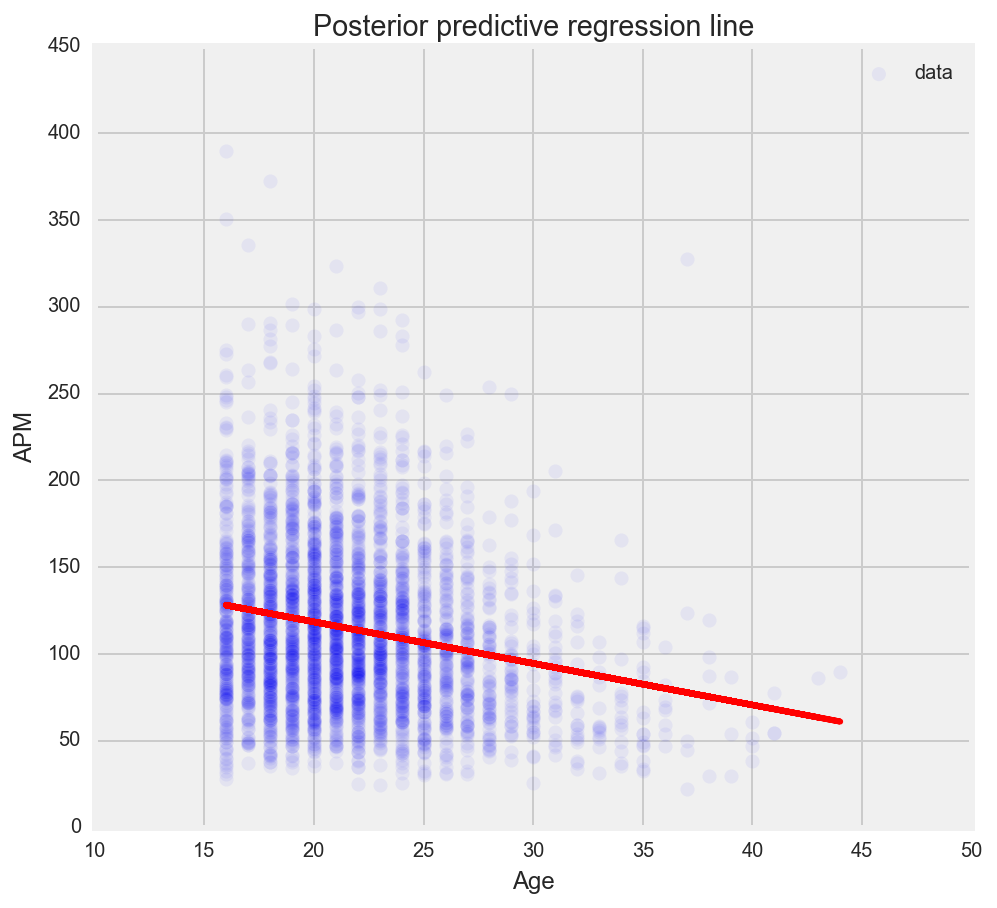

In [31]:
# plot the result
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(star.Age_num.values, star.APM.values,
           s=50, alpha=0.05, label='data')

ax.plot(star.Age_num.values, y_pred, color='red',linewidth=3)

plt.title('Posterior predictive regression line')
plt.legend(loc=0)
plt.xlabel('Age')
plt.ylabel('APM')

plt.show()

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("fIXvC0SyNsw", autoplay=1, theme="light", color="red")

---
## [Optional for Independent Time]
## Perform your own Bayesian regression

Following the Bayesian regression code above, choose a target and predictor and fit a regression model using pymc3.

Fit the same linear regression using sklearn. Are the values for the intercept and the coefficients different? How does changing the parameterization for the prior distributions affect the values of the intercept and coefficients?